In [24]:
import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt
import pylab

# **Band Stop Filter (Appendix 2)**

---

# Specifications 

___

In [25]:
delta = 0.15
tr_band = 4

In [26]:
fp1 = 53.4
fp2 = 73.4
fs2 = fp2-4
fs1 = fp1+4
f = [fp1, fp2, fs1, fs2]
fs = 260

In [27]:
factor = 2*3.14/260
wp1 = f[0]*factor 
wp2 = factor*f[1]
ws1 = factor*f[2]
ws2 = factor*f[3]
w = [wp1, wp2, ws1, ws2]
w = np.array(w, dtype ="f")
w

array([1.2898154, 1.7728924, 1.3864307, 1.6762769], dtype=float32)

In [28]:
import math
omega =np.tan(w/2)
omega

array([0.7522001, 1.225668 , 0.8307561, 1.1114625], dtype=float32)

# Conversion to specifications of a low pass filter (Butterworth Filter)

___

In [29]:
omega_l = math.sqrt(omega[0]*omega[1])
b = omega[1] - omega[0] 

omega_ls1 = -(b*omega[2])/(omega[2]**2-omega_l**2)
omega_ls2 = -(b*omega[3])/(omega[3]**2-omega_l**2)
omega_ls = min(abs(omega_ls1), abs(omega_ls2))
print(omega_ls)


1.6791309841253697


In [30]:
D1 = (1/(1-delta)**2)-1
D2 = (1/(delta**2))-1

In [31]:
N = math.ceil(0.5*math.log10(D2/D1)/math.log10(omega_ls))
omega_c = 1/np.power(D1,(0.5/N))
omega_c
omega_c

1.1004174949714172

# Finding the poles of a filter 

In [32]:
poles = np.zeros([2*N],dtype='complex64')
for k in range(int(2*N)):
	poles[k] = omega_c*np.exp(1.j*np.pi*(2*k + 1 + N)/(2*N))

left_poles = np.zeros([0],dtype='complex64')
for s in poles:
  if(s.real<= 0):
    left_poles=np.append(left_poles,s)
left_poles

array([-0.34004772+1.0465592e+00j, -0.89025646+6.4680916e-01j,
       -1.1004175 +1.3476228e-16j, -0.89025646-6.4680916e-01j,
       -0.34004772-1.0465592e+00j], dtype=complex64)

Text(0.5, 0, 'Real')

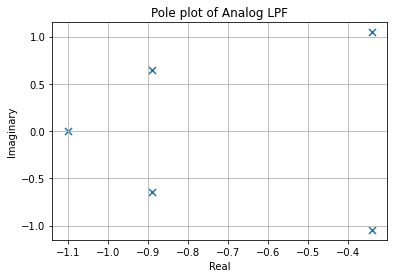

In [33]:

plt.grid(True)	
plt.scatter(left_poles.real,left_poles.imag,s=50,marker='x')
plt.title('Pole plot of Analog LPF')
plt.ylabel('Imaginary')
plt.xlabel('Real')



Text(0.5, 0, 'Real')

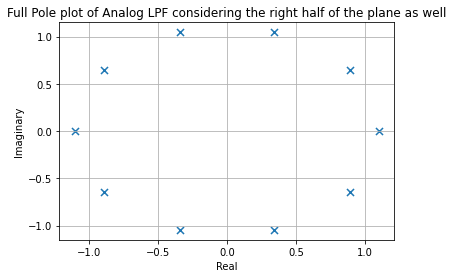

In [34]:

plt.grid(True)	
plt.scatter(poles.real, poles.imag,s=50,marker='x')
plt.title('Full Pole plot of Analog LPF considering the right half of the plane as well')
plt.ylabel('Imaginary')
plt.xlabel('Real')


# Analog LPF to Analog conversion 

Text(0.5, 0, 'Real')

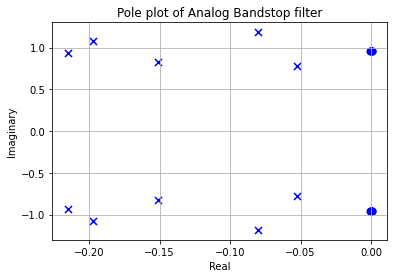

In [35]:
gain = np.power(omega_c,N)
numerator = gain
denominator = 1+0.j
for p in left_poles:
    numerator = np.poly1d([1,0,omega_l**2 ],r=0)*numerator 
    denominator = np.poly1d([-p,b, -p*omega_l**2],r=0)*denominator
z,p,k = sg.tf2zpk(numerator,denominator)


plt.grid(True)
plt.scatter(p.real,p.imag,s=50,c='b',marker='x')
plt.scatter(z.real,z.imag,s=50,c='b',marker='o')
plt.title('Pole plot of Analog Bandstop filter')
plt.ylabel('Imaginary')
plt.xlabel('Real')

# Conversion to digital domain

Text(0.5, 0, 'Real')

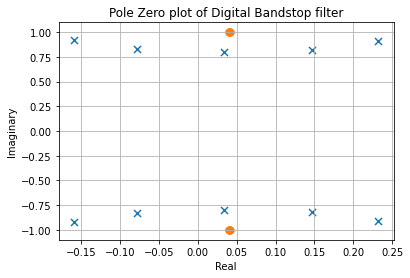

In [36]:
numerator = gain
denominator = 1+0.j
for p in left_poles:
    numerator = np.poly1d([1+omega_l**2 , -2+(2*omega_l**2 ), 1+omega_l**2 ],r=0)*numerator 
    denominator = np.poly1d([-p+b-(p*omega_l**2 ), (2*p)-(2*p*omega_l**2 ) , -p-b-(omega_l**2 *p)],r=0)*denominator
z,p,k = sg.tf2zpk(numerator,denominator)



plt.grid(True)
plt.scatter(p.real,p.imag,s=50,marker='x')
plt.scatter(z.real,z.imag,s=50,marker='o')
plt.title('Pole Zero plot of Digital Bandstop filter')
plt.ylabel('Imaginary')
plt.xlabel('Real')


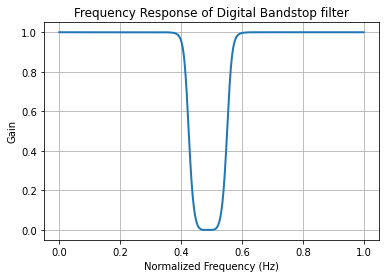

In [37]:

plt.clf()
plt.grid(True)
w,h= sg.freqz(numerator,denominator)
plt.plot((w/max(w)), np.absolute(h), linewidth=2)
plt.xlabel('Normalized Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response of Digital Bandstop filter')
plt.show()

# FIR Filters 

---

Based on the previous question, we already have values for A, beta and N 

In [38]:
A = -20*math.log10(delta)
delta_w = 2*3.14*4000/330000


N = np.ceil((A-8)/(2*2.285*delta_w)) + 5 # Adding an offset of 5 to reduce the ripples in the frequency transfer function

# The Ideal Impulse Response 

In [39]:
wc1= wp1
wc2 = wp2 
iterable   = ((np.sin(wc1*k)-np.sin(wc2*k))/(np.pi*k) for k in range(int(-N),int(N+1)))
h_ideal    = np.fromiter(iterable,float)
h_ideal[int(N)] = ((wc1-wc2)/np.pi)+1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


# Kaiser Window 

In [40]:
h_kaiser = sg.kaiser(2*N+1,0) # Know that the value of beta is 0
h_org    = h_ideal*h_kaiser

# Plotting the Frequency Response of the filter 

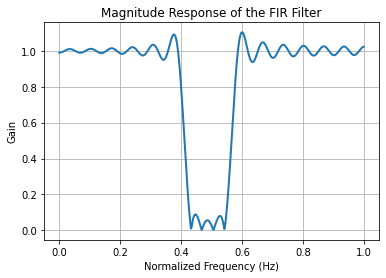

In [41]:
plt.clf()
plt.grid(True)
w,h= sg.freqz(h_org)
plt.plot((w/max(w)), np.absolute(h), linewidth=2)
plt.xlabel('Normalized Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Magnitude Response of the FIR Filter')
plt.show()


# Phase response of the filter 

Text(0.5, 1.0, 'Phase response of the FIR filter')

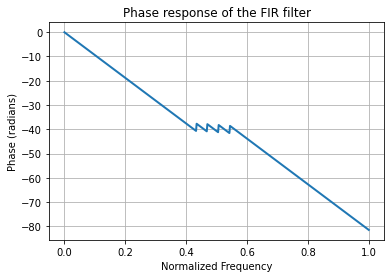

In [42]:
plt.grid(True)

hPhase = pylab.unwrap(np.arctan2(np.imag(h),np.real(h)))
plt.plot(w/max(w),hPhase,linewidth=2)
plt.ylabel('Phase (radians)')
plt.xlabel(r'Normalized Frequency')
plt.title(r'Phase response of the FIR filter')